In [1]:
IOU_THRES = 0.6
NC = 8
class_names = ['Black non occluded', 'Brown  non occluded', 'Gray  non occluded', 'White  non occluded','Black occluded sheep', 'Brown occluded sheep', 'Gray occluded sheep', 'White occluded sheep']
CONF_STEPS = 1001

model = "Baseline-m"

In [2]:
def parseLabel(label: str) -> dict:
    values = label.split()
    dict = {}
    dict["class"] = int(values[0])
    if len(values) > 5:
        dict["conf"] = float(values[5])
    
    xc = float(values[1])
    yc = float(values[2])
    width = float(values[3])
    height = float(values[4])

    dict["x1"] = xc - width / 2
    dict["x2"] = xc + width / 2
    dict["y1"] = yc - height / 2
    dict["y2"] = yc + height / 2

    return dict

def iou(l1: dict, l2: dict):
    x1 = max(l1["x1"], l2["x1"])
    x2 = min(l1["x2"], l2["x2"])
    y1 = max(l1["y1"], l2["y1"])
    y2 = min(l1["y2"], l2["y2"])
    
    ia = max(0, x2 - x1) * max(0, y2 - y1)
    l1a = (l1["x2"] - l1["x1"]) * (l1["y2"] - l1["y1"])
    l2a = (l2["x2"] - l2["x1"]) * (l2["y2"] - l2["y1"])

    ua = l1a + l2a - ia

    return ia / ua

In [3]:
import os
import numpy as np

testLabelDir = f"tests/{model}/labels"
groundTruthLabelDir = f"dataset/labels"

testLabelFiles = list(filter(lambda x: x.endswith("txt"),os.listdir(testLabelDir)))

conf_thresholds = np.linspace(0, 1, CONF_STEPS)

true_positives = np.zeros((NC, len(conf_thresholds)))
false_positives = np.zeros((len(conf_thresholds)))
false_negatives = np.zeros((NC, len(conf_thresholds)))

instance_count = np.zeros((NC))
image_count = len(testLabelFiles)

for labelFile in testLabelFiles:

    with open(f"{groundTruthLabelDir}/{labelFile}") as gFile, open(f"{testLabelDir}/{labelFile}") as tFile:
        gLabels = gFile.readlines()
        tLabels = tFile.readlines()
    
    gBoxes = [parseLabel(label) for label in gLabels]
    proposalBoxes = [parseLabel(label) for label in tLabels]
    tBoxes = []

    for gBox in gBoxes:
        instance_count[gBox["class"]] += 1

    # NMS
    while(len(proposalBoxes) > 0):
        currentBox = proposalBoxes.pop(0)
        tBoxes.append(currentBox)
        for (i, proposalBox) in enumerate(proposalBoxes):
            if iou(currentBox, proposalBox) > IOU_THRES:
                proposalBoxes.pop(i)

    for tBox in tBoxes:
        tp = False
        for (i, gBox) in enumerate(gBoxes):
            if iou(tBox, gBox) > IOU_THRES:
                tp = True

                for (j, conf_threshold) in enumerate(conf_thresholds):
                    if (tBox["conf"] >= conf_threshold):
                        true_positives[gBox["class"]][j] += 1

                    if (conf_threshold > tBox["conf"]):
                        false_negatives[gBox["class"]][j] += 1

                gBoxes.pop(i)
                break
        
        if not tp:
            for (j, conf_threshold) in enumerate(conf_thresholds):
                if (tBox["conf"] >= conf_threshold):
                    false_positives[j] += 1
    
    for (j, conf_threshold) in enumerate(conf_thresholds):
        for gBox in gBoxes:
            false_negatives[gBox["class"]][j] += 1
    



In [4]:
for c, name in enumerate(class_names):
    print(name, true_positives[c][10] / instance_count[c])

Black non occluded 0.9587912087912088
Brown  non occluded 0.9629629629629629
Gray  non occluded 0.981549815498155
White  non occluded 0.9862068965517241
Black occluded sheep 0.625
Brown occluded sheep 0.5
Gray occluded sheep 0.7741935483870968
White occluded sheep 0.8478260869565217


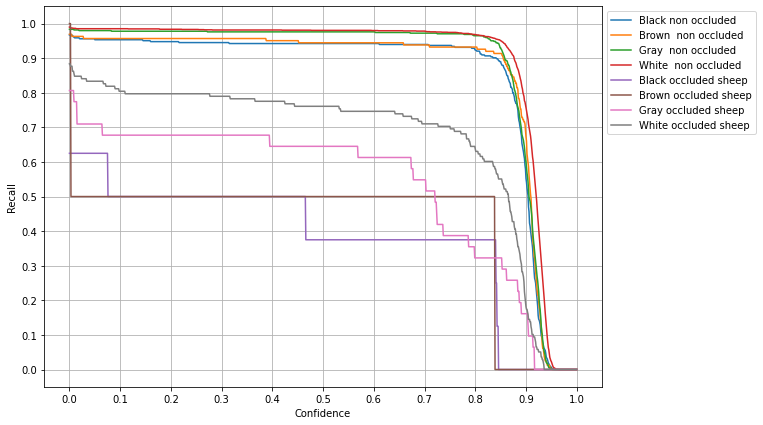

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
ticks = np.linspace(0, 1, 11)

for c in range(NC):
    plt.plot(conf_thresholds, true_positives[c]/instance_count[c], label=class_names[c])

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

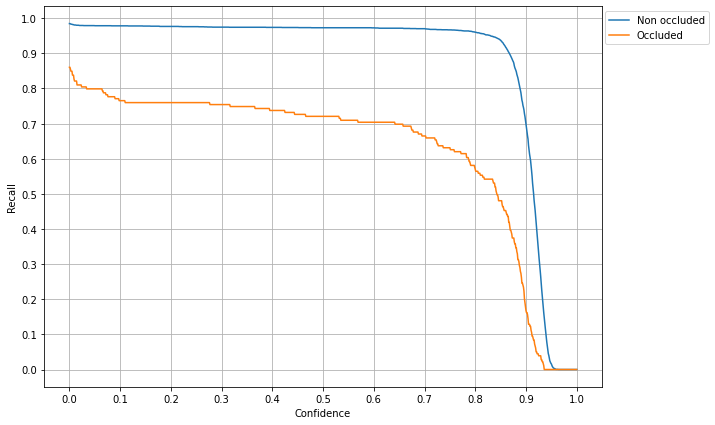

In [6]:
nonoccluded = true_positives[:4, :].sum(axis=0) / instance_count[:4].sum()
occluded = true_positives[4:, :].sum(axis=0) / instance_count[4:].sum()

plt.plot(conf_thresholds, nonoccluded, label="Non occluded")
plt.plot(conf_thresholds, occluded, label="Occluded")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

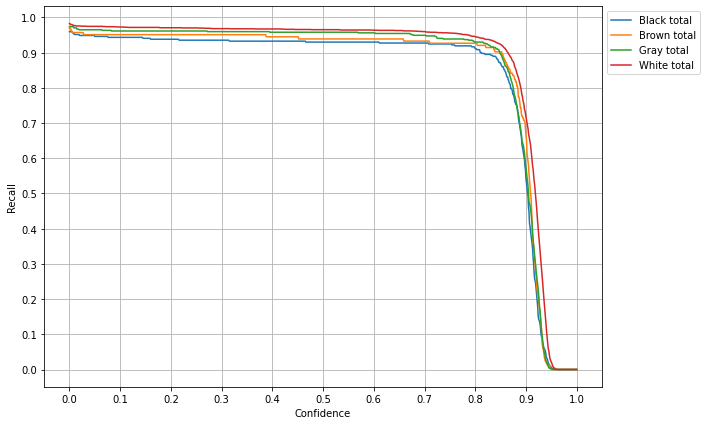

In [7]:
black = true_positives[[0,4], :].sum(axis=0) / instance_count[[0,4]].sum()
brown = true_positives[[1,5], :].sum(axis=0) / instance_count[[1,5]].sum()
gray = true_positives[[2,6], :].sum(axis=0) / instance_count[[2,6]].sum()
white = true_positives[[3,7], :].sum(axis=0) / instance_count[[3,7]].sum()

plt.plot(conf_thresholds, black, label="Black total")
plt.plot(conf_thresholds, brown, label="Brown total")
plt.plot(conf_thresholds, gray, label="Gray total")
plt.plot(conf_thresholds, white, label="White total")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

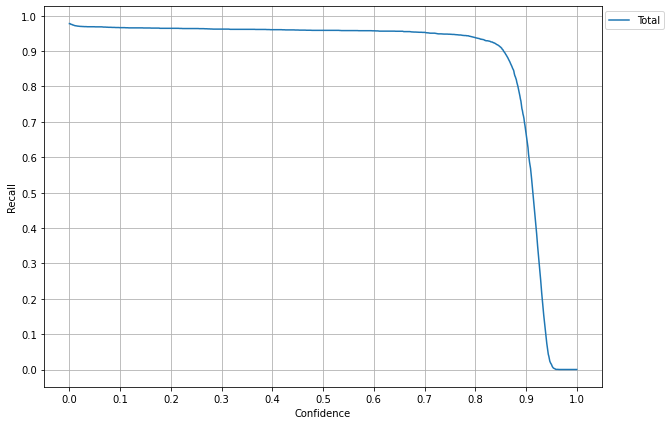

In [8]:
total_recall = true_positives.sum(axis=0) / instance_count.sum()

plt.plot(conf_thresholds, total_recall, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

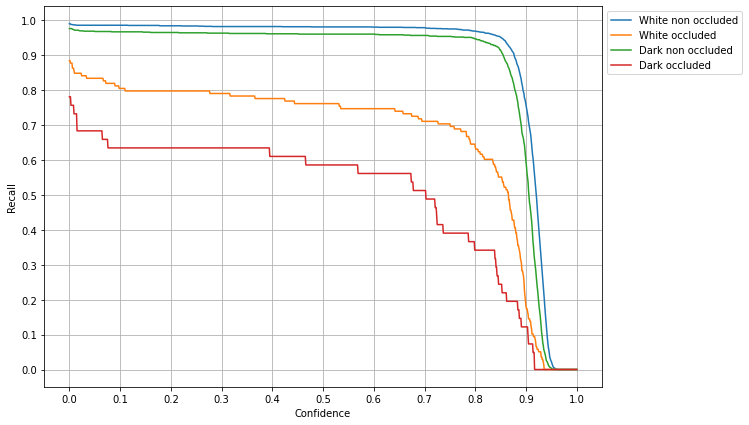

In [9]:
white_non_occ = true_positives[3] / instance_count[3]
white_occ = true_positives[7] / instance_count[7]

dark_non_occ = true_positives[:3].sum(axis=0) / instance_count[:3].sum()
dark_occ = true_positives[4:7].sum(axis=0) / instance_count[4:7].sum()

plt.plot(conf_thresholds, white_non_occ, label="White non occluded")
plt.plot(conf_thresholds, white_occ, label="White occluded")
plt.plot(conf_thresholds, dark_non_occ, label="Dark non occluded")
plt.plot(conf_thresholds, dark_occ, label="Dark occluded")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

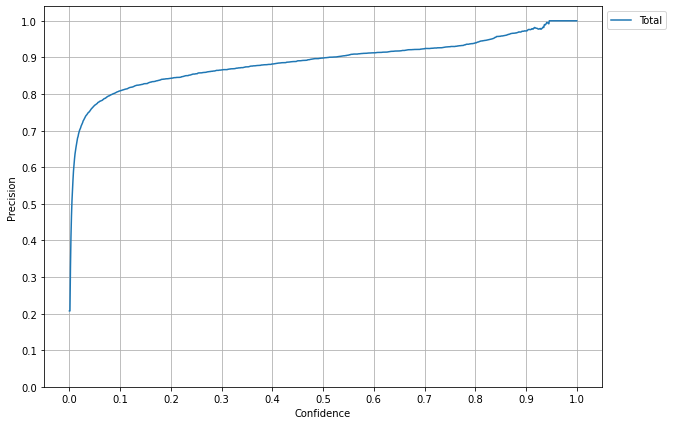

In [10]:
tp_total = true_positives.sum(axis=0)
tp_fp = tp_total + false_positives

precision = np.divide(tp_total, tp_fp, np.ones_like(tp_total), where=(tp_fp > 0))

plt.plot(conf_thresholds, precision, label="Total")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

In [11]:
pr = np.flip(np.column_stack([total_recall, precision]), axis=0)

done = False
precision_recall = np.zeros_like(conf_thresholds)
for i, conf in enumerate(conf_thresholds):
    index = 0
    while index < len(pr) - 1 and pr[index, 0] < conf:
        index += 1
    

    if done:
        precision_recall[i] = 0
    else:
        precision_recall[i] = np.max(pr[index:, 1])
    
    if index + 1 == len(pr):
        done = True


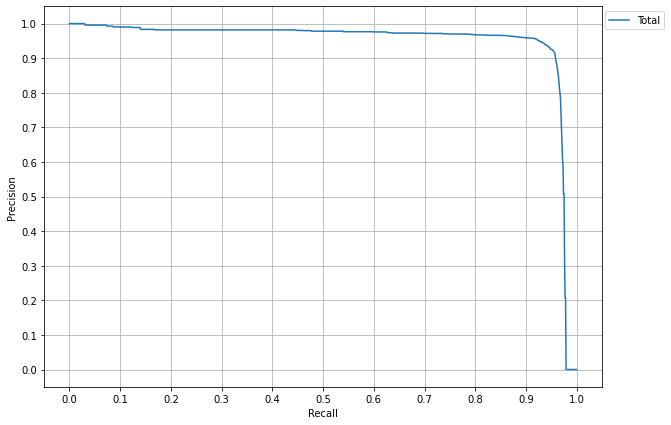

In [12]:
plt.plot(conf_thresholds, precision_recall, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

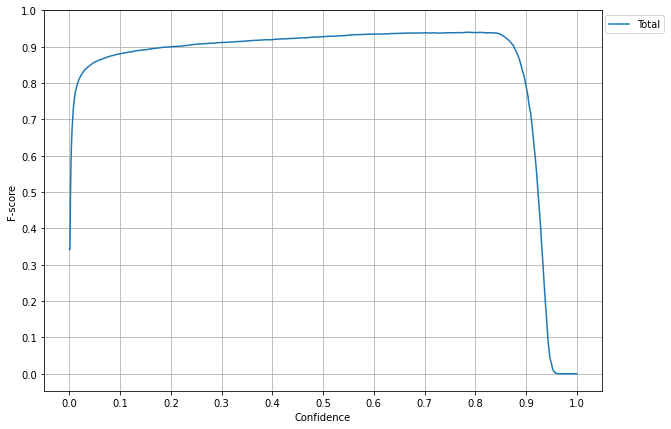

In [13]:
fn_total = false_negatives.sum(axis=0)

f_score = tp_total / (tp_total + 0.5 * (false_positives + fn_total))

plt.plot(conf_thresholds, f_score, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Confidence")
plt.ylabel("F-score")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()